### Libraries

The Baseline code for Learning of a ResNet18 on Cifar10 was inspired by this link initially: 
https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10

In [4]:
# Importing Libraries
import torch
import torchvision
import torchvision.transforms as transforms
# from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

from pytorch_metric_learning.losses import  AngularLoss

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from torchvision import transforms
import numpy as np
import torch

import os

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

C:\Users\ADMIN\anaconda3\envs\my-torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### Transformations and Attacks

In [5]:

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self, augment = False):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]
        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms
    

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + (torch.cuda.FloatTensor(tensor.size()).uniform_()>0.7) * torch.randn(tensor.size()).to(device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# For augmenting on the fly
jitter_transform = transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0)
noise_transform = AddGaussianNoise()


### Download Dataset

In [6]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
data = GetCIFAR10_TrainData(os.chdir(".."))
trainset = data.download_train_data()
testset = data.download_test_data()

Files already downloaded and verified
Files already downloaded and verified


### Create Dataloaders with Stratification

In [11]:
import random

# _______ Get subset of training _____

LEN_TRAIN = 10000

dataset_indices = list(range(LEN_TRAIN))

dataset_indices = np.array([], dtype=int)
dataset_others = np.array([], dtype=int)

targets = np.array(trainset.targets)
MNIST_CLASSES = 10
for c in range(MNIST_CLASSES):
    indices = list(np.argwhere(targets == c).flatten())
    indices_sampled = random.sample(indices, LEN_TRAIN//MNIST_CLASSES)
    indices_other = [a for a in indices if a not in indices_sampled]
    dataset_indices = np.append(dataset_indices, indices_sampled)
    dataset_others = np.append(dataset_others, indices_other)
    
trainset_1 = torch.utils.data.Subset(trainset, dataset_indices)
trainset_2 = torch.utils.data.Subset(trainset, dataset_others)

trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=256,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(trainset_2, batch_size=256,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4)

In [12]:
print(np.unique(np.array(trainset.targets)[dataset_indices], return_counts=True))
print(np.unique(np.array(trainset.targets)[dataset_others], return_counts=True))
print(np.unique(testset.targets, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000],
      dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64))


### RESNET18

In [13]:
class BasicBlock(nn.Module):
    expansion = 1
    

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.reduce = nn.Linear(512*block.expansion, 128*block.expansion)
        self.reduce2 = nn.Linear(128*block.expansion, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, get_representation=False, reduce_representation = False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        
        out = out.view(out.size(0), -1)
        
        if reduce_representation:
            
            if get_representation:
                return torch.nn.functional.normalize(self.reduce(out))
            
            
            out = self.reduce(out)
            out = self.reduce2(out)
            return F.log_softmax(out, dim=-1)

        
        if get_representation:
            return out
        
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)

        
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [15]:
model = ResNet18().to(device)

### K-NN Classifier (For AngularLoss classification)

In [16]:
class KNN_classifier():
    def __init__(self, n_neighbors):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def score(self, X_test, y_test, datasetname):
        acc = self.model.score(X_test, y_test)
        print(f"accuracy on {datasetname} is {acc}%")

### Utilities

In [17]:
def save_model(ckpt_path, model, optimizer=None):
    state_dict = dict()
    state_dict["model"] = model.state_dict()
    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, ckpt_path)


def load_model(ckpt_path, model, optimizer=None):
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

### Training Loop

In [18]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, attack=False, reduce=False, get_representation=False, angular=None):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
                    
        # Apply transformations for attacking
        if attack:
            if random.random() > 0.7:
                data = jitter_transform(data)
            if random.random() > 0.7:
                data = noise_transform(data)
            if random.random() > 0.7:    
                data = fast_gradient_method(model_fn=model, x=data, eps=0.1, norm=np.inf)
                
        optimizer.zero_grad()
        y_pred = model(data.detach(), get_representation=get_representation, reduce_representation=reduce)
        
        # Angular loss works 
        if get_representation:
            loss = angular(y_pred, target)
        else:    
            loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        if not get_representation:
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            # print statistics
            running_loss += loss.item()
            pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)
        else:
            processed += len(data)
            # print statistics
            running_loss += loss.item()
            pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx}')

### Testing

In [20]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

# For getting the accuracy and loss of the model on a specific dataset
def model_testing(model, device, test_dataloader, test_acc, test_losses, attack=False, reduce=False, get_representation=False, angular=None):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    for index, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)

        # Apply transformations for attacking
        if attack:
            if random.random() > 0.7:
                data = jitter_transform(data)
            if random.random() > 0.7:
                data = noise_transform(data)
            if random.random() > 0.7:    
                data = fast_gradient_method(model_fn=model, x=data, eps=0.1, norm=np.inf)
                
        output = model(data, reduce_representation=reduce)
        pred = output.argmax(dim=1, keepdim=True)

        if get_representation:
             test_loss += angular(output, target).item()
        else:
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
        
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    if not get_representation:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_dataloader.dataset),
            100. * correct / len(test_dataloader.dataset)))
        test_acc.append(100. * correct / len(test_dataloader.dataset))
        
    else:
        print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return 0

# This function just runs the data through the model and outputs the representation of the data
def predict(model, device, test_dataloader, attack=False, reduce=False):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    outs = []
    labels = []

    for index, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)

        # Apply transformations for attacking
        if attack:
            if random.random() > 0.7:
                data = jitter_transform(data)
            if random.random() > 0.7:
                data = noise_transform(data)
            if random.random() > 0.7:    
                data = fast_gradient_method(model_fn=model, x=data, eps=0.1, norm=np.inf)
                

        output = model(data, get_representation=True, reduce_representation=reduce)
        if len(outs) == 0:
            outs = output.cpu().detach().numpy()
        else:
            outs = np.append(outs, output.cpu().detach().numpy(), axis = 0)
        labels = np.append(labels, target.cpu().detach().numpy())

    return outs, labels

### Part 1 and 2: Training the baseline model


In [21]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

CKPT_PATH = './ckpt/baseline_ckpt'

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, reduce=True)
    save_model(CKPT_PATH, model, optimizer)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, valloader, test_acc, test_losses, reduce=True)

EPOCHS : 0


Loss=1.95433509349823 Batch_id=39 Accuracy=24.06: 100%|████████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 2.6926, Accuracy: 6028/40000 (15.07%)

EPOCHS : 1


Loss=1.4515578746795654 Batch_id=39 Accuracy=38.52: 100%|██████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]



Test set: Average loss: 1.9255, Accuracy: 12343/40000 (30.86%)

EPOCHS : 2


Loss=1.2316466569900513 Batch_id=39 Accuracy=46.27: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 2.0182, Accuracy: 13438/40000 (33.59%)

EPOCHS : 3


Loss=1.3751941919326782 Batch_id=39 Accuracy=53.08: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 2.5991, Accuracy: 12444/40000 (31.11%)

EPOCHS : 4


Loss=0.9196757078170776 Batch_id=39 Accuracy=56.93: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.04it/s]



Test set: Average loss: 1.4825, Accuracy: 19952/40000 (49.88%)

EPOCHS : 5


Loss=1.3966912031173706 Batch_id=39 Accuracy=62.67: 100%|██████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]



Test set: Average loss: 1.3257, Accuracy: 21882/40000 (54.70%)

EPOCHS : 6


Loss=0.845177948474884 Batch_id=39 Accuracy=65.63: 100%|███████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.2357, Accuracy: 23153/40000 (57.88%)

EPOCHS : 7


Loss=0.9058257937431335 Batch_id=39 Accuracy=69.42: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.2024, Accuracy: 23862/40000 (59.66%)

EPOCHS : 8


Loss=0.6053075194358826 Batch_id=39 Accuracy=73.41: 100%|██████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]



Test set: Average loss: 1.3500, Accuracy: 23616/40000 (59.04%)

EPOCHS : 9


Loss=0.9005305767059326 Batch_id=39 Accuracy=76.18: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.5465, Accuracy: 23312/40000 (58.28%)

EPOCHS : 10


Loss=0.5822738409042358 Batch_id=39 Accuracy=78.03: 100%|██████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]



Test set: Average loss: 1.1480, Accuracy: 25849/40000 (64.62%)

EPOCHS : 11


Loss=0.7297038435935974 Batch_id=39 Accuracy=80.98: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.2878, Accuracy: 24785/40000 (61.96%)

EPOCHS : 12


Loss=0.27820345759391785 Batch_id=39 Accuracy=84.65: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.5015, Accuracy: 24581/40000 (61.45%)

EPOCHS : 13


Loss=0.7712023854255676 Batch_id=39 Accuracy=87.73: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.6611, Accuracy: 23715/40000 (59.29%)

EPOCHS : 14


Loss=0.8298878073692322 Batch_id=39 Accuracy=85.32: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.01it/s]



Test set: Average loss: 1.5447, Accuracy: 24385/40000 (60.96%)

EPOCHS : 15


Loss=0.752312183380127 Batch_id=39 Accuracy=86.24: 100%|███████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.

Test set: Average loss: 2.4469, Accuracy: 20804/40000 (52.01%)

EPOCHS : 16


Loss=0.4306592643260956 Batch_id=39 Accuracy=92.64: 100%|██████████████████████████████| 40/40 [00:15<00:00,  2.57it/s]



Test set: Average loss: 1.0030, Accuracy: 28370/40000 (70.92%)

EPOCHS : 17


Loss=0.21415378153324127 Batch_id=39 Accuracy=96.03: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.00it/s]



Test set: Average loss: 0.9938, Accuracy: 28494/40000 (71.23%)

EPOCHS : 18


Loss=0.3295804560184479 Batch_id=39 Accuracy=97.03: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.04it/s]



Test set: Average loss: 0.9851, Accuracy: 28632/40000 (71.58%)

EPOCHS : 19


Loss=0.3000233769416809 Batch_id=39 Accuracy=97.02: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 0.9817, Accuracy: 28722/40000 (71.81%)

EPOCHS : 20


Loss=0.05955669283866882 Batch_id=39 Accuracy=97.59: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.00it/s]



Test set: Average loss: 0.9917, Accuracy: 28688/40000 (71.72%)

EPOCHS : 21


Loss=0.29286134243011475 Batch_id=39 Accuracy=97.59: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.00it/s]



Test set: Average loss: 0.9968, Accuracy: 28804/40000 (72.01%)

EPOCHS : 22


Loss=0.1649230569601059 Batch_id=39 Accuracy=97.87: 100%|██████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 0.9940, Accuracy: 28841/40000 (72.10%)

EPOCHS : 23


Loss=0.3688145875930786 Batch_id=39 Accuracy=97.97: 100%|██████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]


Epoch 00024: reducing learning rate of group 0 to 2.5000e-05.

Test set: Average loss: 1.0139, Accuracy: 28801/40000 (72.00%)

EPOCHS : 24


Loss=0.10921239107847214 Batch_id=39 Accuracy=98.21: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.01it/s]



Test set: Average loss: 1.0030, Accuracy: 28845/40000 (72.11%)

EPOCHS : 25


Loss=0.20125922560691833 Batch_id=39 Accuracy=98.21: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]



Test set: Average loss: 1.0137, Accuracy: 28797/40000 (71.99%)

EPOCHS : 26


Loss=0.15914762020111084 Batch_id=39 Accuracy=98.37: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]


Epoch 00027: reducing learning rate of group 0 to 1.2500e-06.

Test set: Average loss: 1.0133, Accuracy: 28817/40000 (72.04%)

EPOCHS : 27


Loss=0.380813866853714 Batch_id=39 Accuracy=98.39: 100%|███████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.0090, Accuracy: 28815/40000 (72.04%)

EPOCHS : 28


Loss=0.765130877494812 Batch_id=39 Accuracy=98.37: 100%|███████████████████████████████| 40/40 [00:19<00:00,  2.04it/s]



Test set: Average loss: 1.0075, Accuracy: 28856/40000 (72.14%)

EPOCHS : 29


Loss=0.19532635807991028 Batch_id=39 Accuracy=98.32: 100%|█████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]


Epoch 00030: reducing learning rate of group 0 to 6.2500e-08.

Test set: Average loss: 1.0067, Accuracy: 28817/40000 (72.04%)

EPOCHS : 30


Loss=0.27866560220718384 Batch_id=39 Accuracy=98.35: 100%|█████████████████████████████| 40/40 [00:19<00:00,  2.02it/s]



Test set: Average loss: 1.0122, Accuracy: 28823/40000 (72.06%)

EPOCHS : 31


Loss=0.2723776400089264 Batch_id=39 Accuracy=98.08: 100%|██████████████████████████████| 40/40 [00:16<00:00,  2.49it/s]



Test set: Average loss: 1.0180, Accuracy: 28797/40000 (71.99%)

EPOCHS : 32


Loss=0.2367132008075714 Batch_id=39 Accuracy=98.30: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


Epoch 00033: reducing learning rate of group 0 to 3.1250e-09.

Test set: Average loss: 1.0114, Accuracy: 28832/40000 (72.08%)

EPOCHS : 33


Loss=0.11432026326656342 Batch_id=39 Accuracy=98.42: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0073, Accuracy: 28844/40000 (72.11%)

EPOCHS : 34


Loss=0.2845696806907654 Batch_id=39 Accuracy=98.29: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]



Test set: Average loss: 1.0186, Accuracy: 28778/40000 (71.94%)

EPOCHS : 35


Loss=0.27840617299079895 Batch_id=39 Accuracy=98.29: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0052, Accuracy: 28831/40000 (72.08%)

EPOCHS : 36


Loss=0.4216108024120331 Batch_id=39 Accuracy=98.33: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0120, Accuracy: 28818/40000 (72.05%)

EPOCHS : 37


Loss=0.26550158858299255 Batch_id=39 Accuracy=98.40: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0154, Accuracy: 28774/40000 (71.94%)

EPOCHS : 38


Loss=0.06937863677740097 Batch_id=39 Accuracy=98.53: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0199, Accuracy: 28765/40000 (71.91%)

EPOCHS : 39


Loss=0.15774297714233398 Batch_id=39 Accuracy=98.41: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]



Test set: Average loss: 1.0115, Accuracy: 28848/40000 (72.12%)

EPOCHS : 40


Loss=0.20424117147922516 Batch_id=39 Accuracy=98.42: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]



Test set: Average loss: 1.0173, Accuracy: 28741/40000 (71.85%)

EPOCHS : 41


Loss=0.3128936290740967 Batch_id=39 Accuracy=98.49: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]



Test set: Average loss: 1.0099, Accuracy: 28860/40000 (72.15%)

EPOCHS : 42


Loss=0.09447838366031647 Batch_id=39 Accuracy=98.31: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]



Test set: Average loss: 1.0123, Accuracy: 28829/40000 (72.07%)

EPOCHS : 43


Loss=0.1292206048965454 Batch_id=39 Accuracy=98.29: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0057, Accuracy: 28856/40000 (72.14%)

EPOCHS : 44


Loss=0.14196935296058655 Batch_id=39 Accuracy=98.42: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0135, Accuracy: 28776/40000 (71.94%)

EPOCHS : 45


Loss=0.19013114273548126 Batch_id=39 Accuracy=98.32: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0072, Accuracy: 28883/40000 (72.21%)

EPOCHS : 46


Loss=0.25024673342704773 Batch_id=39 Accuracy=98.40: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]



Test set: Average loss: 1.0184, Accuracy: 28784/40000 (71.96%)

EPOCHS : 47


Loss=0.13831180334091187 Batch_id=39 Accuracy=98.19: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]



Test set: Average loss: 1.0092, Accuracy: 28891/40000 (72.23%)

EPOCHS : 48


Loss=0.11657322943210602 Batch_id=39 Accuracy=98.23: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.0091, Accuracy: 28786/40000 (71.97%)

EPOCHS : 49


Loss=0.3073280453681946 Batch_id=39 Accuracy=98.34: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0177, Accuracy: 28763/40000 (71.91%)

EPOCHS : 50


Loss=0.18422606587409973 Batch_id=39 Accuracy=98.24: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]



Test set: Average loss: 1.0154, Accuracy: 28782/40000 (71.95%)

EPOCHS : 51


Loss=0.058723803609609604 Batch_id=39 Accuracy=98.34: 100%|████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.0081, Accuracy: 28835/40000 (72.09%)

EPOCHS : 52


Loss=0.09744979441165924 Batch_id=39 Accuracy=98.36: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0154, Accuracy: 28788/40000 (71.97%)

EPOCHS : 53


Loss=0.14011402428150177 Batch_id=39 Accuracy=98.38: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0088, Accuracy: 28826/40000 (72.06%)

EPOCHS : 54


Loss=0.07046941667795181 Batch_id=39 Accuracy=98.38: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.0199, Accuracy: 28753/40000 (71.88%)

EPOCHS : 55


Loss=0.1641022264957428 Batch_id=39 Accuracy=98.43: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]



Test set: Average loss: 1.0118, Accuracy: 28734/40000 (71.83%)

EPOCHS : 56


Loss=0.1539928913116455 Batch_id=39 Accuracy=98.47: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0079, Accuracy: 28793/40000 (71.98%)

EPOCHS : 57


Loss=0.44784700870513916 Batch_id=39 Accuracy=98.33: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]



Test set: Average loss: 1.0153, Accuracy: 28805/40000 (72.01%)

EPOCHS : 58


Loss=0.10836675763130188 Batch_id=39 Accuracy=98.18: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0117, Accuracy: 28839/40000 (72.10%)

EPOCHS : 59


Loss=0.08097762614488602 Batch_id=39 Accuracy=98.38: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.84it/s]



Test set: Average loss: 1.0124, Accuracy: 28879/40000 (72.20%)

EPOCHS : 60


Loss=0.3732277452945709 Batch_id=39 Accuracy=98.15: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0216, Accuracy: 28738/40000 (71.84%)

EPOCHS : 61


Loss=0.19301527738571167 Batch_id=39 Accuracy=98.34: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0163, Accuracy: 28757/40000 (71.89%)

EPOCHS : 62


Loss=0.24542683362960815 Batch_id=39 Accuracy=98.07: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.90it/s]



Test set: Average loss: 1.0246, Accuracy: 28770/40000 (71.92%)

EPOCHS : 63


Loss=0.1256454437971115 Batch_id=39 Accuracy=98.31: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]



Test set: Average loss: 1.0073, Accuracy: 28843/40000 (72.11%)

EPOCHS : 64


Loss=0.1887352168560028 Batch_id=39 Accuracy=98.31: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0244, Accuracy: 28745/40000 (71.86%)

EPOCHS : 65


Loss=0.012387966737151146 Batch_id=39 Accuracy=98.14: 100%|████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]



Test set: Average loss: 1.0225, Accuracy: 28686/40000 (71.72%)

EPOCHS : 66


Loss=0.09829534590244293 Batch_id=39 Accuracy=98.39: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0074, Accuracy: 28875/40000 (72.19%)

EPOCHS : 67


Loss=0.48436060547828674 Batch_id=39 Accuracy=98.12: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0207, Accuracy: 28724/40000 (71.81%)

EPOCHS : 68


Loss=0.1375986784696579 Batch_id=39 Accuracy=98.39: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0096, Accuracy: 28816/40000 (72.04%)

EPOCHS : 69


Loss=0.17782339453697205 Batch_id=39 Accuracy=98.26: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0194, Accuracy: 28793/40000 (71.98%)

EPOCHS : 70


Loss=0.15743623673915863 Batch_id=39 Accuracy=98.47: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0074, Accuracy: 28867/40000 (72.17%)

EPOCHS : 71


Loss=0.26793965697288513 Batch_id=39 Accuracy=98.53: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0086, Accuracy: 28849/40000 (72.12%)

EPOCHS : 72


Loss=0.26713132858276367 Batch_id=39 Accuracy=98.44: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.85it/s]



Test set: Average loss: 1.0064, Accuracy: 28830/40000 (72.08%)

EPOCHS : 73


Loss=0.23489217460155487 Batch_id=39 Accuracy=98.32: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.86it/s]



Test set: Average loss: 1.0135, Accuracy: 28821/40000 (72.05%)

EPOCHS : 74


Loss=0.08502175658941269 Batch_id=39 Accuracy=98.30: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.92it/s]



Test set: Average loss: 1.0062, Accuracy: 28864/40000 (72.16%)

EPOCHS : 75


Loss=0.23287610709667206 Batch_id=39 Accuracy=98.41: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.90it/s]



Test set: Average loss: 0.9976, Accuracy: 28898/40000 (72.25%)

EPOCHS : 76


Loss=0.047245945781469345 Batch_id=39 Accuracy=98.50: 100%|████████████████████████████| 40/40 [00:21<00:00,  1.86it/s]



Test set: Average loss: 1.0021, Accuracy: 28880/40000 (72.20%)

EPOCHS : 77


Loss=0.40546390414237976 Batch_id=39 Accuracy=98.29: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0123, Accuracy: 28815/40000 (72.04%)

EPOCHS : 78


Loss=0.18265339732170105 Batch_id=39 Accuracy=98.27: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]



Test set: Average loss: 1.0103, Accuracy: 28851/40000 (72.13%)

EPOCHS : 79


Loss=0.1912621110677719 Batch_id=39 Accuracy=98.09: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.85it/s]



Test set: Average loss: 1.0133, Accuracy: 28808/40000 (72.02%)

EPOCHS : 80


Loss=0.15534289181232452 Batch_id=39 Accuracy=98.49: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.90it/s]



Test set: Average loss: 1.0061, Accuracy: 28839/40000 (72.10%)

EPOCHS : 81


Loss=0.2193976789712906 Batch_id=39 Accuracy=98.23: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.85it/s]



Test set: Average loss: 1.0073, Accuracy: 28870/40000 (72.17%)

EPOCHS : 82


Loss=0.050834864377975464 Batch_id=39 Accuracy=98.48: 100%|████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]



Test set: Average loss: 1.0114, Accuracy: 28815/40000 (72.04%)

EPOCHS : 83


Loss=0.287222683429718 Batch_id=39 Accuracy=98.25: 100%|███████████████████████████████| 40/40 [00:21<00:00,  1.86it/s]



Test set: Average loss: 1.0113, Accuracy: 28823/40000 (72.06%)

EPOCHS : 84


Loss=0.4087682366371155 Batch_id=39 Accuracy=98.23: 100%|██████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]



Test set: Average loss: 1.0040, Accuracy: 28876/40000 (72.19%)

EPOCHS : 85


Loss=0.07012245804071426 Batch_id=39 Accuracy=98.26: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.90it/s]



Test set: Average loss: 1.0063, Accuracy: 28848/40000 (72.12%)

EPOCHS : 86


Loss=0.08342570066452026 Batch_id=39 Accuracy=98.43: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0086, Accuracy: 28845/40000 (72.11%)

EPOCHS : 87


Loss=0.07360661774873734 Batch_id=39 Accuracy=98.47: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]



Test set: Average loss: 1.0191, Accuracy: 28777/40000 (71.94%)

EPOCHS : 88


Loss=0.2427077740430832 Batch_id=39 Accuracy=98.44: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0089, Accuracy: 28891/40000 (72.23%)

EPOCHS : 89


Loss=0.16499000787734985 Batch_id=39 Accuracy=98.32: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]



Test set: Average loss: 1.0139, Accuracy: 28774/40000 (71.94%)

EPOCHS : 90


Loss=0.12420647591352463 Batch_id=39 Accuracy=98.45: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0146, Accuracy: 28769/40000 (71.92%)

EPOCHS : 91


Loss=0.10619544982910156 Batch_id=39 Accuracy=98.35: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]



Test set: Average loss: 1.0188, Accuracy: 28777/40000 (71.94%)

EPOCHS : 92


Loss=0.564069390296936 Batch_id=39 Accuracy=98.26: 100%|███████████████████████████████| 40/40 [00:22<00:00,  1.74it/s]



Test set: Average loss: 1.0173, Accuracy: 28789/40000 (71.97%)

EPOCHS : 93


Loss=0.08150119334459305 Batch_id=39 Accuracy=98.40: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0061, Accuracy: 28859/40000 (72.15%)

EPOCHS : 94


Loss=0.13512171804904938 Batch_id=39 Accuracy=98.35: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0154, Accuracy: 28823/40000 (72.06%)

EPOCHS : 95


Loss=0.09960593283176422 Batch_id=39 Accuracy=98.31: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0190, Accuracy: 28746/40000 (71.86%)

EPOCHS : 96


Loss=0.19397321343421936 Batch_id=39 Accuracy=98.28: 100%|█████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



Test set: Average loss: 1.0136, Accuracy: 28817/40000 (72.04%)

EPOCHS : 97


Loss=0.09465394169092178 Batch_id=39 Accuracy=98.08: 100%|█████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]



Test set: Average loss: 1.0145, Accuracy: 28843/40000 (72.11%)

EPOCHS : 98


Loss=0.4021492004394531 Batch_id=39 Accuracy=98.35: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]



Test set: Average loss: 1.0112, Accuracy: 28814/40000 (72.03%)

EPOCHS : 99


Loss=0.3249906301498413 Batch_id=39 Accuracy=98.25: 100%|██████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]



Test set: Average loss: 1.0143, Accuracy: 28790/40000 (71.97%)



### Statistics

In [22]:
model, _ = load_model('./ckpt/baseline_ckpt', model, optimizer)
misclassified = model_testing(model, device, testloader, test_acc, test_losses, reduce=True)


Test set: Average loss: 1.0562, Accuracy: 7093/10000 (70.93%)



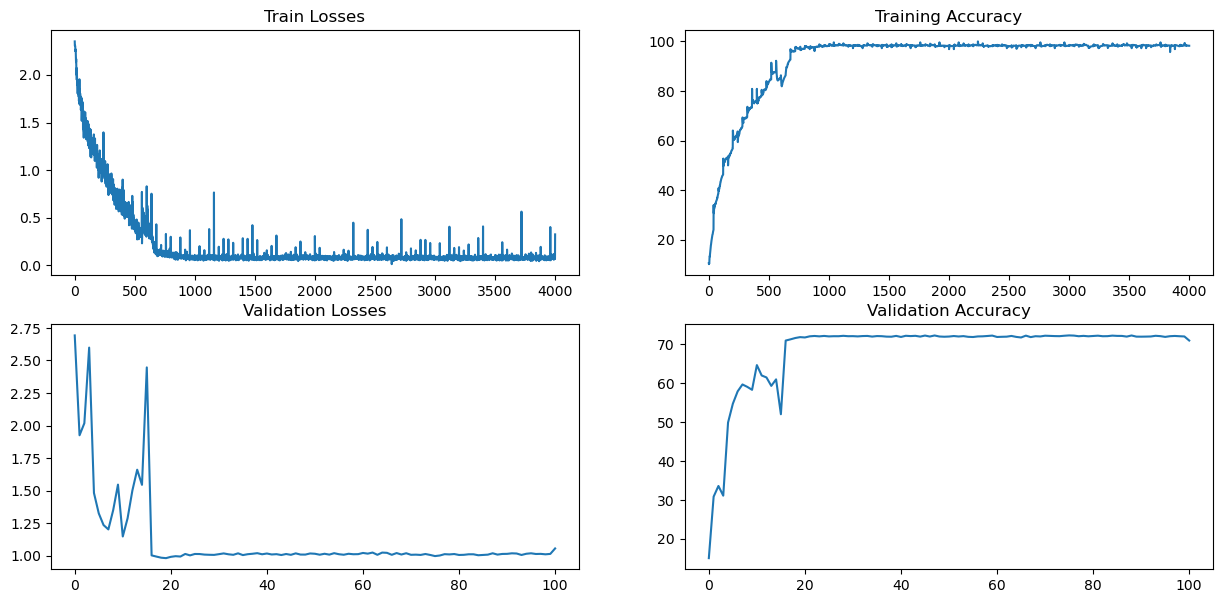

In [29]:
fig, axs = plt.subplots(2,2, figsize=(15,7))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Validation Losses')
axs[1,1].set_title('Validation Accuracy')


axs[0,0].plot([a.cpu().detach().numpy() for a in train_losses])
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

### UMAP

In [30]:
import umap.umap_ as umap

def get_umap_representation(train_rep, val_rep, test_rep):
    uma = umap.UMAP()
    print("Fit")
    uma.fit(train_rep[:500])
    print("Train")
    dest_train_embeddings = uma.transform(train_rep[:500])
    print("Val")
    dest_val_embeddings = uma.transform(val_rep[:500])
    print("Test")
    dest_test_embeddings = uma.transform(test_rep[:500])
    return dest_train_embeddings, dest_val_embeddings, dest_test_embeddings


In [ ]:
model = ResNet18().to(device)
model, _ = load_model(CKPT_PATH, model, optimizer)
test_rep, test_lab = predict(model, device, testloader, reduce=True)
val_rep, val_lab = predict(model, device, valloader, reduce=True)
train_rep, train_lab = predict(model, device, trainloader, reduce=True)

In [34]:
train_umap, val_umap, test_umap = get_umap_representation(train_rep, val_rep, test_rep)

Fit
Train
Val
Test


In [35]:
np.shape(train_rep[:500])

(500, 128)

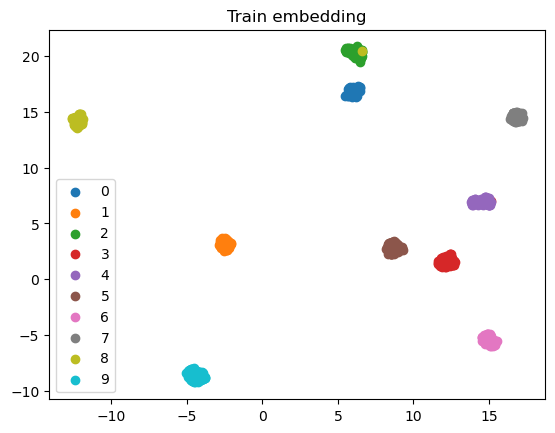

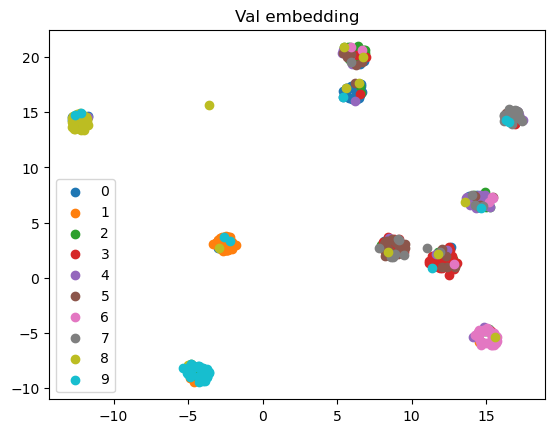

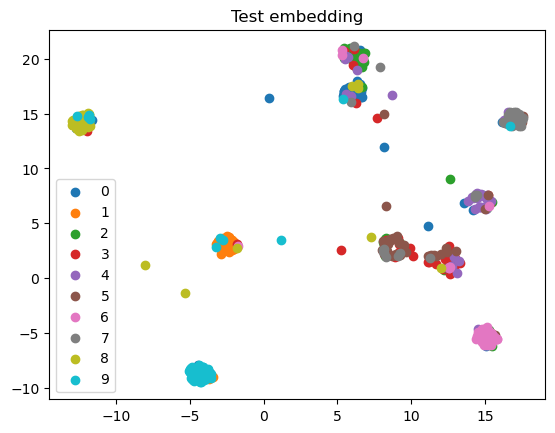

In [37]:
np.shape(test_umap)

for l in np.unique(train_lab):
    plt.scatter(train_umap[:, 0][train_lab[:500]==l], train_umap[:, 1][train_lab[:500]==l], label=int(l))
plt.title("Train embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(val_umap[:, 0][val_lab[:500]==l], val_umap[:, 1][val_lab[:500]==l], label=int(l))
plt.title("Val embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(test_umap[:, 0][test_lab[:500]==l], test_umap[:, 1][test_lab[:500]==l], label=int(l))
plt.legend()
plt.title("Test embedding")
plt.show()

### Part 3: Create attack transformations

In [38]:

def plot_images(loader, attack=False, model=None):
    mean=[0.491, 0.482, 0.446]
    std=[0.247, 0.243, 0.261]

    batch_data = next(iter(loader))
    data, _ = batch_data
    data = data.to(device)
    
    # Apply transformations for attacking
    if attack:
        if random.random() > 0.7:
            data = jitter_transform(data)
        data = noise_transform(data)
        if model:
            data = fast_gradient_method(model_fn=model, x=data, eps=0.1, norm=np.inf)
    
    imgs = data.cpu().detach().numpy().transpose((0, 2, 3, 1))[:4]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        im_denormalized = np.array(std) * imgs[i] + np.array(mean)
        im_denormalized = im_denormalized.clip(0, 1)

        plt.imshow(im_denormalized)
    plt.show()

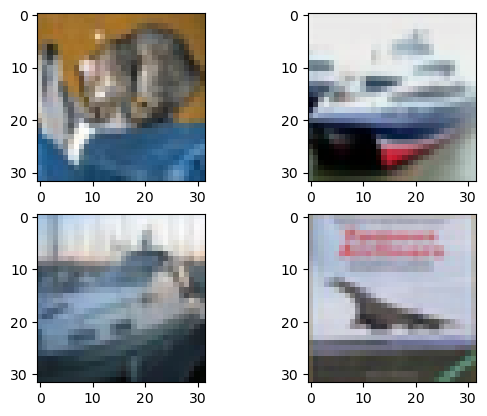

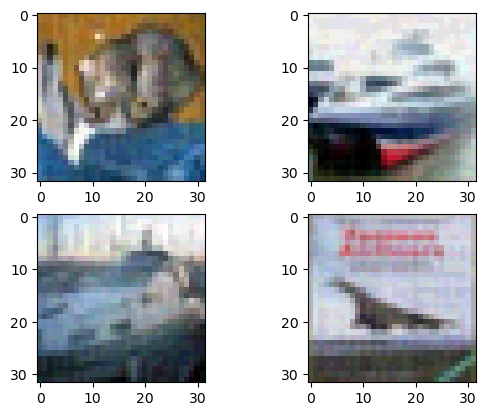

In [39]:
plot_images(testloader, False, model)    
plot_images(testloader, True, model)

### Attack test dataset and make predictions 

In [40]:
misclassified = model_testing(model, device, testloader, test_acc, test_losses, attack=True, reduce=True)


Test set: Average loss: 2.5865, Accuracy: 4656/10000 (46.56%)



### UMAP of attacked model

In [41]:
model = ResNet18().to(device)
model, _ = load_model(CKPT_PATH, model, optimizer)
test_rep, test_lab = predict(model, device, testloader, attack=True, reduce=True)
train_rep, train_lab = predict(model, device, trainloader, attack=True, reduce=True)
val_rep, val_lab = predict(model, device, valloader, attack=True, reduce=True)

In [42]:
train_umap, val_umap, test_umap = get_umap_representation(train_rep, val_rep, test_rep)

Fit
Train
Val
Test


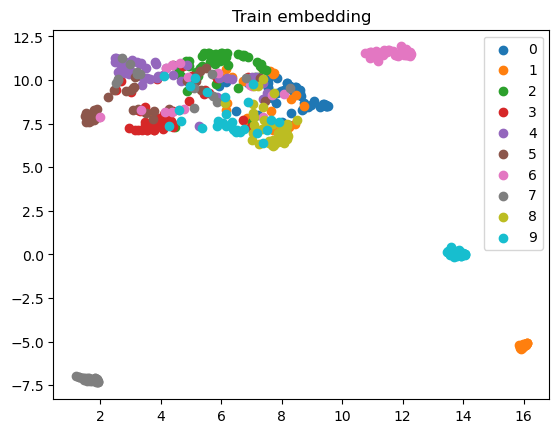

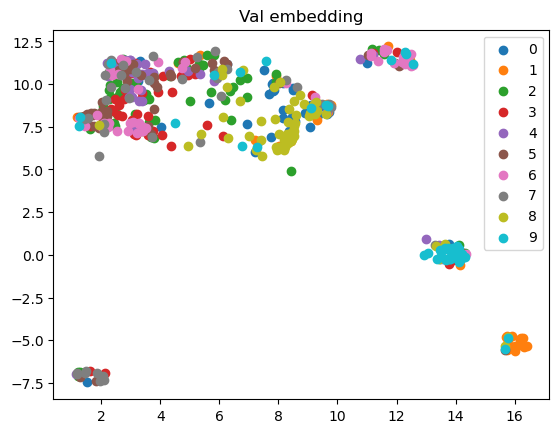

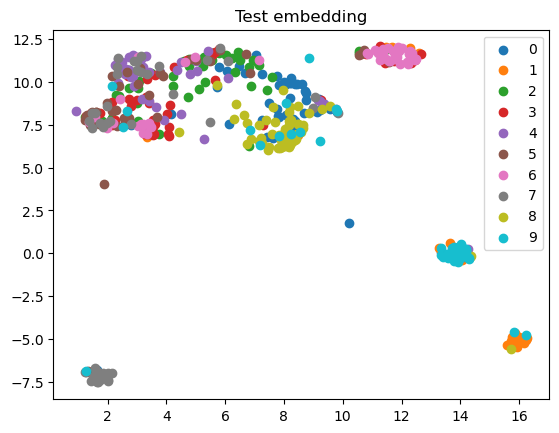

In [43]:
np.shape(test_umap)

for l in np.unique(train_lab):
    plt.scatter(train_umap[:, 0][train_lab[:500]==l], train_umap[:, 1][train_lab[:500]==l], label=int(l))
plt.title("Train embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(val_umap[:, 0][val_lab[:500]==l], val_umap[:, 1][val_lab[:500]==l], label=int(l))
plt.title("Val embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(test_umap[:, 0][test_lab[:500]==l], test_umap[:, 1][test_lab[:500]==l], label=int(l))
plt.legend()
plt.title("Test embedding")
plt.show()

### Part 4: Adversarial Training

In [44]:

model = ResNet18().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

CKPT_PATH = './ckpt/adversarial_ckpt'

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, attack=True, reduce=True)
    save_model(CKPT_PATH, model, optimizer)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, valloader, test_acc, test_losses, reduce=True)

EPOCHS : 0


Loss=1.6770362854003906 Batch_id=39 Accuracy=21.61: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 2.0141, Accuracy: 9768/40000 (24.42%)

EPOCHS : 1


Loss=1.975019931793213 Batch_id=39 Accuracy=34.72: 100%|███████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 1.7019, Accuracy: 15308/40000 (38.27%)

EPOCHS : 2


Loss=1.4579753875732422 Batch_id=39 Accuracy=42.41: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]



Test set: Average loss: 1.5633, Accuracy: 17181/40000 (42.95%)

EPOCHS : 3


Loss=1.3150126934051514 Batch_id=39 Accuracy=47.09: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.58it/s]



Test set: Average loss: 1.5457, Accuracy: 18556/40000 (46.39%)

EPOCHS : 4


Loss=1.6453840732574463 Batch_id=39 Accuracy=51.74: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.70it/s]



Test set: Average loss: 1.6953, Accuracy: 19234/40000 (48.09%)

EPOCHS : 5


Loss=0.8430904150009155 Batch_id=39 Accuracy=53.87: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]



Test set: Average loss: 1.5816, Accuracy: 19348/40000 (48.37%)

EPOCHS : 6


Loss=0.8021794557571411 Batch_id=39 Accuracy=57.46: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 1.3747, Accuracy: 20964/40000 (52.41%)

EPOCHS : 7


Loss=0.889329195022583 Batch_id=39 Accuracy=60.34: 100%|███████████████████████████████| 40/40 [00:25<00:00,  1.54it/s]



Test set: Average loss: 1.3617, Accuracy: 21891/40000 (54.73%)

EPOCHS : 8


Loss=1.4404466152191162 Batch_id=39 Accuracy=61.64: 100%|██████████████████████████████| 40/40 [00:27<00:00,  1.45it/s]



Test set: Average loss: 1.2151, Accuracy: 23423/40000 (58.56%)

EPOCHS : 9


Loss=1.1655648946762085 Batch_id=39 Accuracy=65.98: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.

Test set: Average loss: 1.1441, Accuracy: 24221/40000 (60.55%)

EPOCHS : 10


Loss=0.7663315534591675 Batch_id=39 Accuracy=70.62: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9478, Accuracy: 26737/40000 (66.84%)

EPOCHS : 11


Loss=0.7071940302848816 Batch_id=39 Accuracy=72.65: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 0.9673, Accuracy: 26671/40000 (66.68%)

EPOCHS : 12


Loss=0.6256674528121948 Batch_id=39 Accuracy=74.99: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]



Test set: Average loss: 0.9808, Accuracy: 26501/40000 (66.25%)

EPOCHS : 13


Loss=0.6078372001647949 Batch_id=39 Accuracy=74.29: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 0.9422, Accuracy: 26963/40000 (67.41%)

EPOCHS : 14


Loss=0.9550906419754028 Batch_id=39 Accuracy=74.64: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.52it/s]



Test set: Average loss: 0.9944, Accuracy: 26471/40000 (66.18%)

EPOCHS : 15


Loss=0.6117322444915771 Batch_id=39 Accuracy=76.36: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]



Test set: Average loss: 0.9229, Accuracy: 27269/40000 (68.17%)

EPOCHS : 16


Loss=0.9351210594177246 Batch_id=39 Accuracy=78.70: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.66it/s]


Epoch 00017: reducing learning rate of group 0 to 2.5000e-05.

Test set: Average loss: 0.9470, Accuracy: 27188/40000 (67.97%)

EPOCHS : 17


Loss=0.738161027431488 Batch_id=39 Accuracy=79.68: 100%|███████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]



Test set: Average loss: 0.8982, Accuracy: 27548/40000 (68.87%)

EPOCHS : 18


Loss=1.0211982727050781 Batch_id=39 Accuracy=79.41: 100%|██████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]



Test set: Average loss: 0.9666, Accuracy: 26914/40000 (67.28%)

EPOCHS : 19


Loss=0.6865538954734802 Batch_id=39 Accuracy=74.92: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]


Epoch 00020: reducing learning rate of group 0 to 1.2500e-06.

Test set: Average loss: 1.0612, Accuracy: 25972/40000 (64.93%)

EPOCHS : 20


Loss=1.5087666511535645 Batch_id=39 Accuracy=77.83: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 0.9850, Accuracy: 26783/40000 (66.96%)

EPOCHS : 21


Loss=0.4391685724258423 Batch_id=39 Accuracy=78.27: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 0.9548, Accuracy: 27042/40000 (67.61%)

EPOCHS : 22


Loss=0.8632331490516663 Batch_id=39 Accuracy=76.62: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 1.0460, Accuracy: 26084/40000 (65.21%)

EPOCHS : 23


Loss=1.0321273803710938 Batch_id=39 Accuracy=76.72: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.54it/s]



Test set: Average loss: 0.9397, Accuracy: 27270/40000 (68.17%)

EPOCHS : 24


Loss=0.9318729043006897 Batch_id=39 Accuracy=77.00: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


Epoch 00025: reducing learning rate of group 0 to 6.2500e-08.

Test set: Average loss: 0.9684, Accuracy: 26920/40000 (67.30%)

EPOCHS : 25


Loss=0.8346197009086609 Batch_id=39 Accuracy=76.88: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]



Test set: Average loss: 0.9629, Accuracy: 26952/40000 (67.38%)

EPOCHS : 26


Loss=0.5019997358322144 Batch_id=39 Accuracy=77.65: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]



Test set: Average loss: 0.9116, Accuracy: 27455/40000 (68.64%)

EPOCHS : 27


Loss=0.5016907453536987 Batch_id=39 Accuracy=79.13: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.66it/s]


Epoch 00028: reducing learning rate of group 0 to 3.1250e-09.

Test set: Average loss: 0.9064, Accuracy: 27508/40000 (68.77%)

EPOCHS : 28


Loss=0.9281080365180969 Batch_id=39 Accuracy=76.79: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]



Test set: Average loss: 1.0699, Accuracy: 25828/40000 (64.57%)

EPOCHS : 29


Loss=0.8520804643630981 Batch_id=39 Accuracy=76.54: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]



Test set: Average loss: 1.0165, Accuracy: 26414/40000 (66.03%)

EPOCHS : 30


Loss=0.7752346992492676 Batch_id=39 Accuracy=78.61: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]



Test set: Average loss: 0.9224, Accuracy: 27378/40000 (68.44%)

EPOCHS : 31


Loss=0.5641155242919922 Batch_id=39 Accuracy=79.82: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]



Test set: Average loss: 0.9181, Accuracy: 27462/40000 (68.66%)

EPOCHS : 32


Loss=0.9955311417579651 Batch_id=39 Accuracy=78.17: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]



Test set: Average loss: 0.8979, Accuracy: 27617/40000 (69.04%)

EPOCHS : 33


Loss=0.7147030234336853 Batch_id=39 Accuracy=77.90: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 0.9137, Accuracy: 27499/40000 (68.75%)

EPOCHS : 34


Loss=0.6788696646690369 Batch_id=39 Accuracy=74.70: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 1.1186, Accuracy: 25394/40000 (63.48%)

EPOCHS : 35


Loss=0.839792013168335 Batch_id=39 Accuracy=80.05: 100%|███████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9538, Accuracy: 27019/40000 (67.55%)

EPOCHS : 36


Loss=0.3948765993118286 Batch_id=39 Accuracy=77.66: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9313, Accuracy: 27155/40000 (67.89%)

EPOCHS : 37


Loss=0.6646642088890076 Batch_id=39 Accuracy=76.84: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9270, Accuracy: 27283/40000 (68.21%)

EPOCHS : 38


Loss=0.6985296010971069 Batch_id=39 Accuracy=77.08: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 0.9284, Accuracy: 27307/40000 (68.27%)

EPOCHS : 39


Loss=0.7888040542602539 Batch_id=39 Accuracy=78.79: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 0.9027, Accuracy: 27514/40000 (68.78%)

EPOCHS : 40


Loss=0.6429584622383118 Batch_id=39 Accuracy=78.41: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 0.9130, Accuracy: 27381/40000 (68.45%)

EPOCHS : 41


Loss=1.1181704998016357 Batch_id=39 Accuracy=76.52: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]



Test set: Average loss: 0.9236, Accuracy: 27361/40000 (68.40%)

EPOCHS : 42


Loss=0.5281050205230713 Batch_id=39 Accuracy=77.67: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.71it/s]



Test set: Average loss: 0.9302, Accuracy: 27357/40000 (68.39%)

EPOCHS : 43


Loss=0.6671082973480225 Batch_id=39 Accuracy=78.37: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 0.9267, Accuracy: 27306/40000 (68.27%)

EPOCHS : 44


Loss=0.8068987727165222 Batch_id=39 Accuracy=79.16: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9218, Accuracy: 27371/40000 (68.43%)

EPOCHS : 45


Loss=1.307644009590149 Batch_id=39 Accuracy=76.12: 100%|███████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 0.9441, Accuracy: 27149/40000 (67.87%)

EPOCHS : 46


Loss=0.4206829369068146 Batch_id=39 Accuracy=76.89: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.66it/s]



Test set: Average loss: 0.9390, Accuracy: 27218/40000 (68.05%)

EPOCHS : 47


Loss=0.6285486221313477 Batch_id=39 Accuracy=79.81: 100%|██████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]



Test set: Average loss: 0.9025, Accuracy: 27553/40000 (68.88%)

EPOCHS : 48


Loss=0.8044384121894836 Batch_id=39 Accuracy=78.75: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 0.9115, Accuracy: 27439/40000 (68.60%)

EPOCHS : 49


Loss=0.7272605299949646 Batch_id=39 Accuracy=77.43: 100%|██████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]



Test set: Average loss: 0.9668, Accuracy: 26903/40000 (67.26%)

EPOCHS : 50


Loss=0.39198219776153564 Batch_id=39 Accuracy=79.46: 100%|█████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 0.9014, Accuracy: 27507/40000 (68.77%)

EPOCHS : 51


Loss=0.2955354154109955 Batch_id=39 Accuracy=78.01: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.68it/s]



Test set: Average loss: 0.9633, Accuracy: 26934/40000 (67.33%)

EPOCHS : 52


Loss=1.4421614408493042 Batch_id=39 Accuracy=76.91: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 1.0242, Accuracy: 26341/40000 (65.85%)

EPOCHS : 53


Loss=0.5464645028114319 Batch_id=39 Accuracy=76.88: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]



Test set: Average loss: 1.0624, Accuracy: 25942/40000 (64.86%)

EPOCHS : 54


Loss=0.5832574963569641 Batch_id=39 Accuracy=74.29: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.54it/s]



Test set: Average loss: 0.9415, Accuracy: 27162/40000 (67.91%)

EPOCHS : 55


Loss=0.6960374116897583 Batch_id=39 Accuracy=78.79: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9066, Accuracy: 27496/40000 (68.74%)

EPOCHS : 56


Loss=0.8128525018692017 Batch_id=39 Accuracy=76.71: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]



Test set: Average loss: 0.9429, Accuracy: 27165/40000 (67.91%)

EPOCHS : 57


Loss=0.8770750164985657 Batch_id=39 Accuracy=77.06: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.60it/s]



Test set: Average loss: 0.9533, Accuracy: 27054/40000 (67.64%)

EPOCHS : 58


Loss=1.0368435382843018 Batch_id=39 Accuracy=78.61: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 0.9106, Accuracy: 27502/40000 (68.75%)

EPOCHS : 59


Loss=0.8721747994422913 Batch_id=39 Accuracy=77.50: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 0.9606, Accuracy: 26977/40000 (67.44%)

EPOCHS : 60


Loss=0.45027288794517517 Batch_id=39 Accuracy=76.95: 100%|█████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]



Test set: Average loss: 0.9733, Accuracy: 26867/40000 (67.17%)

EPOCHS : 61


Loss=0.7085800170898438 Batch_id=39 Accuracy=76.62: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9743, Accuracy: 26862/40000 (67.16%)

EPOCHS : 62


Loss=0.3833681344985962 Batch_id=39 Accuracy=77.40: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9763, Accuracy: 26840/40000 (67.10%)

EPOCHS : 63


Loss=0.9795728325843811 Batch_id=39 Accuracy=75.77: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 1.1388, Accuracy: 25199/40000 (63.00%)

EPOCHS : 64


Loss=0.7394276857376099 Batch_id=39 Accuracy=78.50: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.58it/s]



Test set: Average loss: 0.8926, Accuracy: 27661/40000 (69.15%)

EPOCHS : 65


Loss=0.8429862856864929 Batch_id=39 Accuracy=78.51: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]



Test set: Average loss: 0.8993, Accuracy: 27617/40000 (69.04%)

EPOCHS : 66


Loss=1.3242552280426025 Batch_id=39 Accuracy=77.36: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9560, Accuracy: 26977/40000 (67.44%)

EPOCHS : 67


Loss=0.7926363945007324 Batch_id=39 Accuracy=77.60: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]



Test set: Average loss: 0.9249, Accuracy: 27354/40000 (68.39%)

EPOCHS : 68


Loss=0.8231016397476196 Batch_id=39 Accuracy=77.70: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.57it/s]



Test set: Average loss: 0.9365, Accuracy: 27213/40000 (68.03%)

EPOCHS : 69


Loss=0.6152703762054443 Batch_id=39 Accuracy=75.74: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]



Test set: Average loss: 0.9460, Accuracy: 27116/40000 (67.79%)

EPOCHS : 70


Loss=1.3035883903503418 Batch_id=39 Accuracy=75.22: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 1.2507, Accuracy: 24121/40000 (60.30%)

EPOCHS : 71


Loss=1.5879641771316528 Batch_id=39 Accuracy=76.00: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 1.0197, Accuracy: 26421/40000 (66.05%)

EPOCHS : 72


Loss=0.6122115850448608 Batch_id=39 Accuracy=77.59: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.73it/s]



Test set: Average loss: 0.9924, Accuracy: 26657/40000 (66.64%)

EPOCHS : 73


Loss=0.534337043762207 Batch_id=39 Accuracy=78.88: 100%|███████████████████████████████| 40/40 [00:23<00:00,  1.68it/s]



Test set: Average loss: 0.9189, Accuracy: 27413/40000 (68.53%)

EPOCHS : 74


Loss=1.0147122144699097 Batch_id=39 Accuracy=77.77: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 0.9856, Accuracy: 26770/40000 (66.92%)

EPOCHS : 75


Loss=0.7510505318641663 Batch_id=39 Accuracy=75.86: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]



Test set: Average loss: 0.9493, Accuracy: 27114/40000 (67.78%)

EPOCHS : 76


Loss=0.7729330062866211 Batch_id=39 Accuracy=78.41: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9068, Accuracy: 27469/40000 (68.67%)

EPOCHS : 77


Loss=0.4425225257873535 Batch_id=39 Accuracy=78.78: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.60it/s]



Test set: Average loss: 0.9071, Accuracy: 27473/40000 (68.68%)

EPOCHS : 78


Loss=0.7510172724723816 Batch_id=39 Accuracy=77.49: 100%|██████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]



Test set: Average loss: 0.9336, Accuracy: 27285/40000 (68.21%)

EPOCHS : 79


Loss=0.45971962809562683 Batch_id=39 Accuracy=76.19: 100%|█████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]



Test set: Average loss: 1.0234, Accuracy: 26320/40000 (65.80%)

EPOCHS : 80


Loss=0.44478827714920044 Batch_id=39 Accuracy=74.93: 100%|█████████████████████████████| 40/40 [00:26<00:00,  1.52it/s]



Test set: Average loss: 1.0154, Accuracy: 26446/40000 (66.11%)

EPOCHS : 81


Loss=1.2859195470809937 Batch_id=39 Accuracy=76.90: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.52it/s]



Test set: Average loss: 0.9096, Accuracy: 27496/40000 (68.74%)

EPOCHS : 82


Loss=0.662767767906189 Batch_id=39 Accuracy=76.31: 100%|███████████████████████████████| 40/40 [00:25<00:00,  1.54it/s]



Test set: Average loss: 0.9337, Accuracy: 27288/40000 (68.22%)

EPOCHS : 83


Loss=0.8573359847068787 Batch_id=39 Accuracy=78.92: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 0.9932, Accuracy: 26624/40000 (66.56%)

EPOCHS : 84


Loss=0.7290903329849243 Batch_id=39 Accuracy=77.70: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 0.9318, Accuracy: 27334/40000 (68.33%)

EPOCHS : 85


Loss=0.9477872252464294 Batch_id=39 Accuracy=75.23: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 1.2061, Accuracy: 24590/40000 (61.48%)

EPOCHS : 86


Loss=0.42803463339805603 Batch_id=39 Accuracy=77.59: 100%|█████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]



Test set: Average loss: 0.9232, Accuracy: 27367/40000 (68.42%)

EPOCHS : 87


Loss=0.865556001663208 Batch_id=39 Accuracy=77.99: 100%|███████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]



Test set: Average loss: 0.9104, Accuracy: 27500/40000 (68.75%)

EPOCHS : 88


Loss=0.36179637908935547 Batch_id=39 Accuracy=76.85: 100%|█████████████████████████████| 40/40 [00:24<00:00,  1.66it/s]



Test set: Average loss: 0.9432, Accuracy: 27165/40000 (67.91%)

EPOCHS : 89


Loss=1.3495571613311768 Batch_id=39 Accuracy=77.49: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9887, Accuracy: 26689/40000 (66.72%)

EPOCHS : 90


Loss=0.8681825399398804 Batch_id=39 Accuracy=76.22: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.9166, Accuracy: 27394/40000 (68.48%)

EPOCHS : 91


Loss=0.6363069415092468 Batch_id=39 Accuracy=77.25: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]



Test set: Average loss: 0.9132, Accuracy: 27465/40000 (68.66%)

EPOCHS : 92


Loss=0.9522837996482849 Batch_id=39 Accuracy=75.26: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.69it/s]



Test set: Average loss: 1.0348, Accuracy: 26310/40000 (65.78%)

EPOCHS : 93


Loss=0.656755268573761 Batch_id=39 Accuracy=76.48: 100%|███████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]



Test set: Average loss: 0.9345, Accuracy: 27219/40000 (68.05%)

EPOCHS : 94


Loss=0.5023712515830994 Batch_id=39 Accuracy=78.34: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.8990, Accuracy: 27537/40000 (68.84%)

EPOCHS : 95


Loss=0.5020739436149597 Batch_id=39 Accuracy=77.56: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.61it/s]



Test set: Average loss: 1.0081, Accuracy: 26479/40000 (66.20%)

EPOCHS : 96


Loss=0.2873397767543793 Batch_id=39 Accuracy=78.33: 100%|██████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]



Test set: Average loss: 0.8981, Accuracy: 27600/40000 (69.00%)

EPOCHS : 97


Loss=0.9341467022895813 Batch_id=39 Accuracy=75.97: 100%|██████████████████████████████| 40/40 [00:26<00:00,  1.50it/s]



Test set: Average loss: 1.0156, Accuracy: 26412/40000 (66.03%)

EPOCHS : 98


Loss=0.8026901483535767 Batch_id=39 Accuracy=78.33: 100%|██████████████████████████████| 40/40 [00:25<00:00,  1.56it/s]



Test set: Average loss: 0.9167, Accuracy: 27416/40000 (68.54%)

EPOCHS : 99


Loss=0.7449930906295776 Batch_id=39 Accuracy=78.36: 100%|██████████████████████████████| 40/40 [00:23<00:00,  1.71it/s]



Test set: Average loss: 0.9165, Accuracy: 27465/40000 (68.66%)



### Statistics

In [46]:
misclassified = model_testing(model, device, testloader, test_acc, test_losses, reduce=True)


Test set: Average loss: 0.9299, Accuracy: 6846/10000 (68.46%)



In [47]:
misclassified = model_testing(model, device, testloader, test_acc, test_losses, attack=True, reduce=True)


Test set: Average loss: 1.5619, Accuracy: 5192/10000 (51.92%)



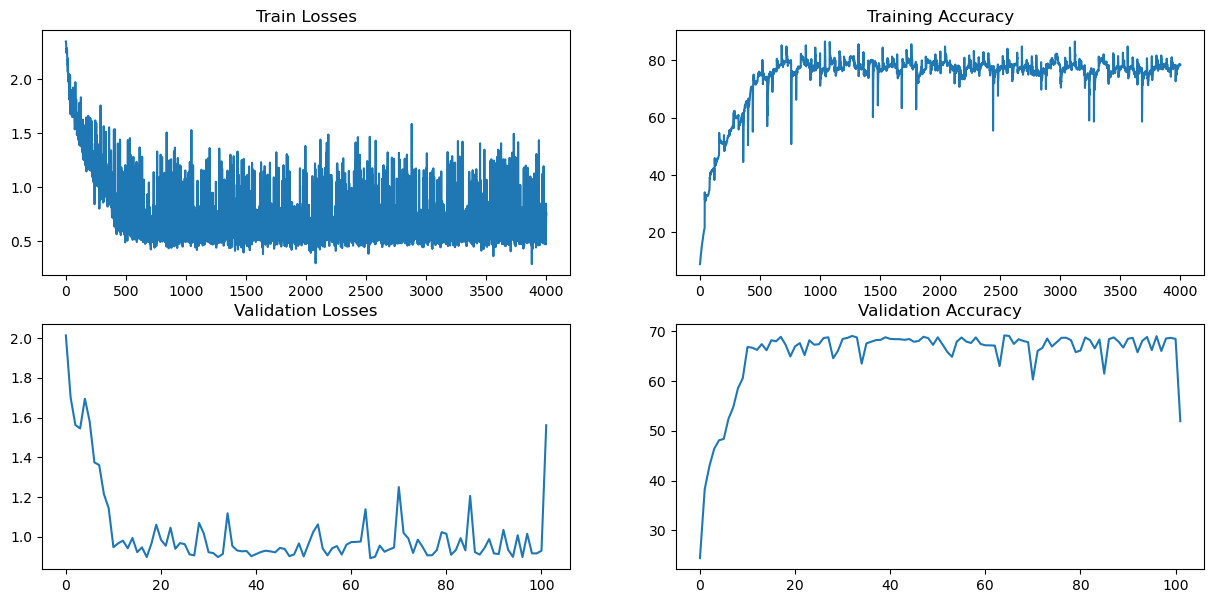

In [48]:
fig, axs = plt.subplots(2,2, figsize=(15,7))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Validation Losses')
axs[1,1].set_title('Validation Accuracy')


axs[0,0].plot([a.cpu().detach().numpy() for a in train_losses])
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

### UMAP

In [49]:
model = ResNet18().to(device)
load_model(CKPT_PATH, model, optimizer)
test_rep, test_lab = predict(model, device, testloader, attack=True, reduce=True)
train_rep, train_lab = predict(model, device, trainloader, attack=True, reduce=True)
val_rep, val_lab = predict(model, device, valloader, attack=True, reduce=True)

In [50]:
train_umap, val_umap, test_umap = get_umap_representation(train_rep, val_rep, test_rep)

Fit
Train
Val
Test


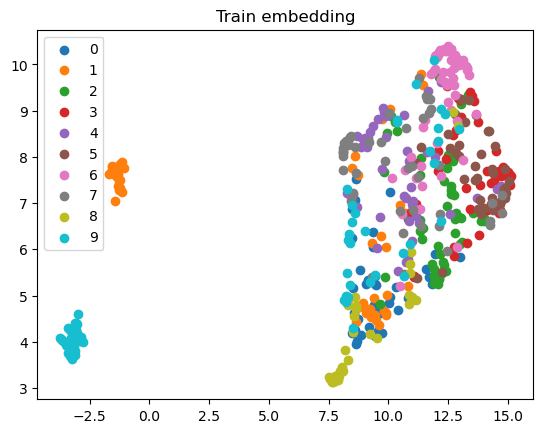

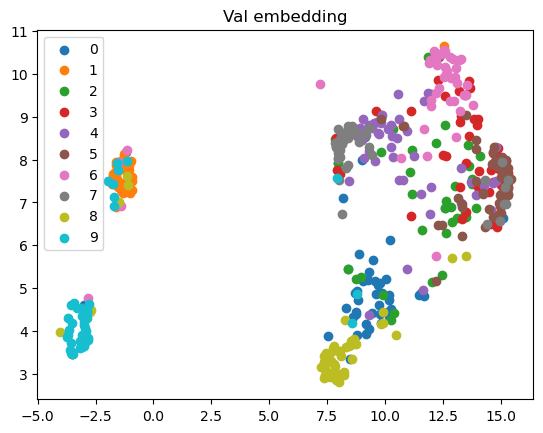

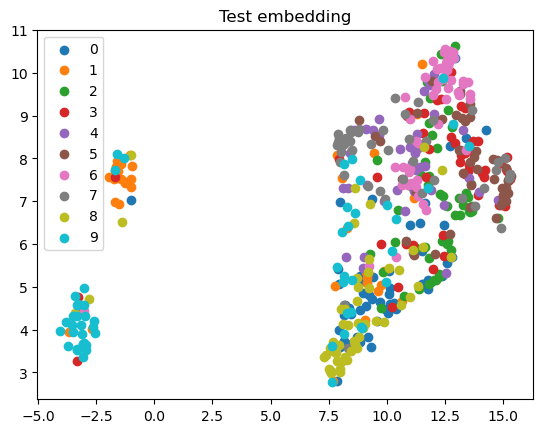

In [51]:
np.shape(test_umap)

for l in np.unique(train_lab):
    plt.scatter(train_umap[:, 0][train_lab[:500]==l], train_umap[:, 1][train_lab[:500]==l], label=int(l))
plt.title("Train embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(val_umap[:, 0][val_lab[:500]==l], val_umap[:, 1][val_lab[:500]==l], label=int(l))
plt.title("Val embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(test_umap[:, 0][test_lab[:500]==l], test_umap[:, 1][test_lab[:500]==l], label=int(l))
plt.legend()
plt.title("Test embedding")
plt.show()

### Part 6: AngularLoss

### Create Custom Dataloader by BatchSampler

Code for the batch sampler class was taken from here: https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/65198/4


In [52]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler


class BalancedBatchSampler(BatchSampler):

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [58]:
# Here the batch size becomes 260 instead of 256 in order to get the same number of data from each class

balanced_batch_sampler1 = BalancedBatchSampler(trainset_1, n_classes=10, n_samples=26)
balanced_batch_sampler2 = BalancedBatchSampler(trainset_2, n_classes=10, n_samples=26)

trainloader = torch.utils.data.DataLoader(trainset_1,
                                          num_workers=4, batch_sampler=balanced_batch_sampler1)
valloader = torch.utils.data.DataLoader(trainset_2,
                                           num_workers=4, batch_sampler=balanced_batch_sampler2)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4)

my_testiter = next(iter(valloader))
images, target = my_testiter
print(np.unique(target.detach().cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([26, 26, 26, 26, 26, 26, 26, 26, 26, 26], dtype=int64))


### Training AngularLoss

In [60]:

model = ResNet18().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

CKPT_PATH = './ckpt/angular_ckpt'

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, reduce=True, get_representation=True, angular=AngularLoss(alpha=45))
    save_model(CKPT_PATH, model, optimizer)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, valloader, test_acc, test_losses, reduce=True, get_representation=True, angular=AngularLoss(alpha=45))

EPOCHS : 0


Loss=5.793744087219238 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:19<00:00,  1.92it/s]



Test set: Average loss: 0.2296

EPOCHS : 1


Loss=5.574073314666748 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:19<00:00,  1.90it/s]



Test set: Average loss: 0.2302

EPOCHS : 2


Loss=5.491617679595947 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.89it/s]



Test set: Average loss: 0.2301

EPOCHS : 3


Loss=5.4056525230407715 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:19<00:00,  1.92it/s]



Test set: Average loss: 0.2302

EPOCHS : 4


Loss=5.307945251464844 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:19<00:00,  1.90it/s]



Test set: Average loss: 0.2311

EPOCHS : 5


Loss=5.201300621032715 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.90it/s]



Test set: Average loss: 0.2304

EPOCHS : 6


Loss=5.098830223083496 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:19<00:00,  1.92it/s]



Test set: Average loss: 0.2326

EPOCHS : 7


Loss=5.193630695343018 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.89it/s]



Test set: Average loss: 0.2472

EPOCHS : 8


Loss=4.888734817504883 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:19<00:00,  1.90it/s]



Test set: Average loss: 0.2544

EPOCHS : 9


Loss=4.80017614364624 Batch_id=37: 100%|███████████████████████████████████████████████| 38/38 [00:20<00:00,  1.88it/s]



Test set: Average loss: 0.2451

EPOCHS : 10


Loss=4.593441009521484 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.2389

EPOCHS : 11


Loss=4.526697635650635 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.87it/s]



Test set: Average loss: 0.2784

EPOCHS : 12


Loss=4.632063388824463 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.85it/s]



Test set: Average loss: 0.2533

EPOCHS : 13


Loss=4.349776744842529 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.2700

EPOCHS : 14


Loss=4.129762649536133 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.85it/s]



Test set: Average loss: 0.2792

EPOCHS : 15


Loss=4.085879802703857 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.87it/s]



Test set: Average loss: 0.2741

EPOCHS : 16


Loss=3.6139614582061768 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.2789

EPOCHS : 17


Loss=3.9885029792785645 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.82it/s]



Test set: Average loss: 0.2950

EPOCHS : 18


Loss=4.011868476867676 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.87it/s]



Test set: Average loss: 0.3205

EPOCHS : 19


Loss=3.426955223083496 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.87it/s]



Test set: Average loss: 0.2937

EPOCHS : 20


Loss=3.956171751022339 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.87it/s]



Test set: Average loss: 0.3472

EPOCHS : 21


Loss=3.3460042476654053 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.84it/s]



Test set: Average loss: 0.3047

EPOCHS : 22


Loss=2.7931747436523438 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3304

EPOCHS : 23


Loss=3.001112937927246 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3322

EPOCHS : 24


Loss=3.002728223800659 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3818

EPOCHS : 25


Loss=3.1750288009643555 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.88it/s]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.

Test set: Average loss: 0.3401

EPOCHS : 26


Loss=2.1803364753723145 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3460

EPOCHS : 27


Loss=1.8097875118255615 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3441

EPOCHS : 28


Loss=1.8674734830856323 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.84it/s]



Test set: Average loss: 0.3511

EPOCHS : 29


Loss=1.7420185804367065 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3430

EPOCHS : 30


Loss=1.7373642921447754 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:20<00:00,  1.86it/s]



Test set: Average loss: 0.3499

EPOCHS : 31


Loss=1.4460240602493286 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.16it/s]



Test set: Average loss: 0.3452

EPOCHS : 32


Loss=1.6630687713623047 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3471

EPOCHS : 33


Loss=1.3931583166122437 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3489

EPOCHS : 34


Loss=1.524949073791504 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3530

EPOCHS : 35


Loss=1.4785826206207275 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3525

EPOCHS : 36


Loss=1.4504886865615845 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]


Epoch 00037: reducing learning rate of group 0 to 2.5000e-05.

Test set: Average loss: 0.3507

EPOCHS : 37


Loss=1.4089406728744507 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.16it/s]



Test set: Average loss: 0.3511

EPOCHS : 38


Loss=1.3882389068603516 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.13it/s]



Test set: Average loss: 0.3514

EPOCHS : 39


Loss=1.603205680847168 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.22it/s]



Test set: Average loss: 0.3524

EPOCHS : 40


Loss=1.4614075422286987 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.22it/s]



Test set: Average loss: 0.3547

EPOCHS : 41


Loss=1.4055107831954956 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]


Epoch 00042: reducing learning rate of group 0 to 1.2500e-06.

Test set: Average loss: 0.3539

EPOCHS : 42


Loss=1.4360697269439697 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.23it/s]



Test set: Average loss: 0.3526

EPOCHS : 43


Loss=1.3352184295654297 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.21it/s]



Test set: Average loss: 0.3540

EPOCHS : 44


Loss=1.397210955619812 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3544

EPOCHS : 45


Loss=1.6435209512710571 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3502

EPOCHS : 46


Loss=1.458908200263977 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:16<00:00,  2.29it/s]


Epoch 00047: reducing learning rate of group 0 to 6.2500e-08.

Test set: Average loss: 0.3506

EPOCHS : 47


Loss=1.3518497943878174 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3541

EPOCHS : 48


Loss=1.4748378992080688 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.15it/s]



Test set: Average loss: 0.3537

EPOCHS : 49


Loss=1.4250850677490234 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 00050: reducing learning rate of group 0 to 3.1250e-09.

Test set: Average loss: 0.3528

EPOCHS : 50


Loss=1.4526751041412354 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3544

EPOCHS : 51


Loss=1.630064606666565 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3540

EPOCHS : 52


Loss=1.4388010501861572 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.16it/s]



Test set: Average loss: 0.3517

EPOCHS : 53


Loss=1.5385903120040894 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.16it/s]



Test set: Average loss: 0.3523

EPOCHS : 54


Loss=1.3882248401641846 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3521

EPOCHS : 55


Loss=1.375778317451477 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3533

EPOCHS : 56


Loss=1.3718528747558594 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3530

EPOCHS : 57


Loss=1.3773865699768066 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3528

EPOCHS : 58


Loss=1.3699456453323364 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.15it/s]



Test set: Average loss: 0.3523

EPOCHS : 59


Loss=1.4951248168945312 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3530

EPOCHS : 60


Loss=1.4240256547927856 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3539

EPOCHS : 61


Loss=1.4097201824188232 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.14it/s]



Test set: Average loss: 0.3518

EPOCHS : 62


Loss=1.422033667564392 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.16it/s]



Test set: Average loss: 0.3514

EPOCHS : 63


Loss=1.4063814878463745 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3531

EPOCHS : 64


Loss=1.3739402294158936 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3529

EPOCHS : 65


Loss=1.3685177564620972 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3537

EPOCHS : 66


Loss=1.404242753982544 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:16<00:00,  2.28it/s]



Test set: Average loss: 0.3525

EPOCHS : 67


Loss=1.4086291790008545 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.21it/s]



Test set: Average loss: 0.3518

EPOCHS : 68


Loss=1.3751835823059082 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3550

EPOCHS : 69


Loss=1.3901002407073975 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3521

EPOCHS : 70


Loss=1.3440964221954346 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3543

EPOCHS : 71


Loss=1.4100950956344604 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.23it/s]



Test set: Average loss: 0.3539

EPOCHS : 72


Loss=1.3778668642044067 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.15it/s]



Test set: Average loss: 0.3531

EPOCHS : 73


Loss=1.4199590682983398 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.24it/s]



Test set: Average loss: 0.3555

EPOCHS : 74


Loss=1.4864723682403564 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.27it/s]



Test set: Average loss: 0.3501

EPOCHS : 75


Loss=1.3726234436035156 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3534

EPOCHS : 76


Loss=1.5606019496917725 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3528

EPOCHS : 77


Loss=1.4949314594268799 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.26it/s]



Test set: Average loss: 0.3537

EPOCHS : 78


Loss=1.3453800678253174 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3510

EPOCHS : 79


Loss=1.7262980937957764 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3500

EPOCHS : 80


Loss=1.4901739358901978 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.15it/s]



Test set: Average loss: 0.3523

EPOCHS : 81


Loss=1.3473031520843506 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3540

EPOCHS : 82


Loss=1.3749624490737915 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.22it/s]



Test set: Average loss: 0.3563

EPOCHS : 83


Loss=1.491324782371521 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:16<00:00,  2.25it/s]



Test set: Average loss: 0.3538

EPOCHS : 84


Loss=1.3211690187454224 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:16<00:00,  2.30it/s]



Test set: Average loss: 0.3529

EPOCHS : 85


Loss=1.42844820022583 Batch_id=37: 100%|███████████████████████████████████████████████| 38/38 [00:17<00:00,  2.23it/s]



Test set: Average loss: 0.3541

EPOCHS : 86


Loss=1.3973244428634644 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.23it/s]



Test set: Average loss: 0.3548

EPOCHS : 87


Loss=1.4624943733215332 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3510

EPOCHS : 88


Loss=1.522320032119751 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3519

EPOCHS : 89


Loss=1.3876290321350098 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.15it/s]



Test set: Average loss: 0.3555

EPOCHS : 90


Loss=1.4761667251586914 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.18it/s]



Test set: Average loss: 0.3541

EPOCHS : 91


Loss=1.4091265201568604 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.23it/s]



Test set: Average loss: 0.3543

EPOCHS : 92


Loss=1.4774963855743408 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3520

EPOCHS : 93


Loss=1.3663777112960815 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.20it/s]



Test set: Average loss: 0.3544

EPOCHS : 94


Loss=1.4428634643554688 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3533

EPOCHS : 95


Loss=1.4646433591842651 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]



Test set: Average loss: 0.3533

EPOCHS : 96


Loss=1.4756606817245483 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.14it/s]



Test set: Average loss: 0.3530

EPOCHS : 97


Loss=1.3575068712234497 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3531

EPOCHS : 98


Loss=1.413338303565979 Batch_id=37: 100%|██████████████████████████████████████████████| 38/38 [00:17<00:00,  2.17it/s]



Test set: Average loss: 0.3515

EPOCHS : 99


Loss=1.5131523609161377 Batch_id=37: 100%|█████████████████████████████████████████████| 38/38 [00:18<00:00,  2.10it/s]



Test set: Average loss: 0.3540



### Statistics

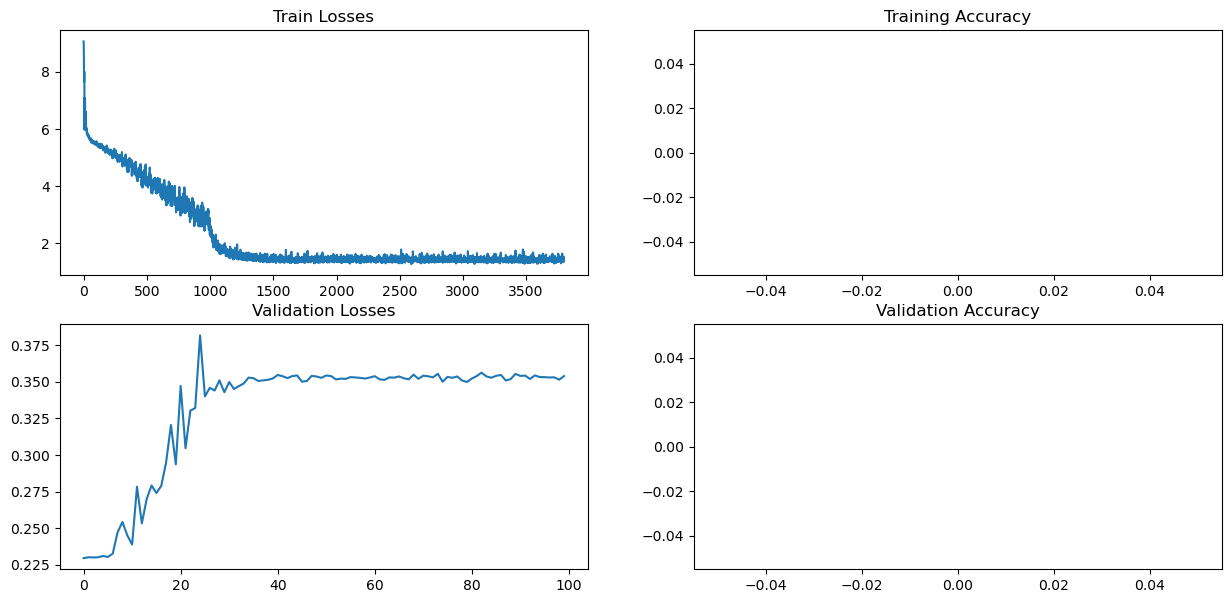

In [61]:
fig, axs = plt.subplots(2,2, figsize=(15,7))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Validation Losses')
axs[1,1].set_title('Validation Accuracy')


axs[0,0].plot([a.cpu().detach().numpy() for a in train_losses])
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

### KNN classification

In [74]:
test_rep, test_lab = predict(model, device, testloader, reduce=True)
train_rep, train_lab = predict(model, device, trainloader, reduce=True)
val_rep, val_lab = predict(model, device, valloader, reduce=True)

In [76]:
KNN = KNN_classifier(3)
KNN.fit(train_rep, train_lab)
KNN.score(train_rep, train_lab, 'Train dataset')
KNN.score(val_rep, val_lab, 'Val dataset')
KNN.score(test_rep, test_lab, 'Test dataset')

accuracy on Train dataset is 0.9982793522267206%
accuracy on Val dataset is 0.726797385620915%
accuracy on Test dataset is 0.7327%


In [77]:
test_rep, test_lab = predict(model, device, testloader, attack=True, reduce=True)
train_rep, train_lab = predict(model, device, trainloader, attack=True, reduce=True)
val_rep, val_lab = predict(model, device, valloader, attack=True, reduce=True)

In [78]:
KNN.score(train_rep, train_lab, 'Train dataset attack')
KNN.score(val_rep, val_lab, 'Val dataset attack')
KNN.score(test_rep, test_lab, 'Test dataset attack')

accuracy on Train dataset attack is 0.7279352226720648%
accuracy on Val dataset attack is 0.4963298139768728%
accuracy on Test dataset attack is 0.5207%


### UMAP

In [79]:
train_umap, val_umap, test_umap = get_umap_representation(train_rep, val_rep, test_rep)

Fit
Train
Val
Test


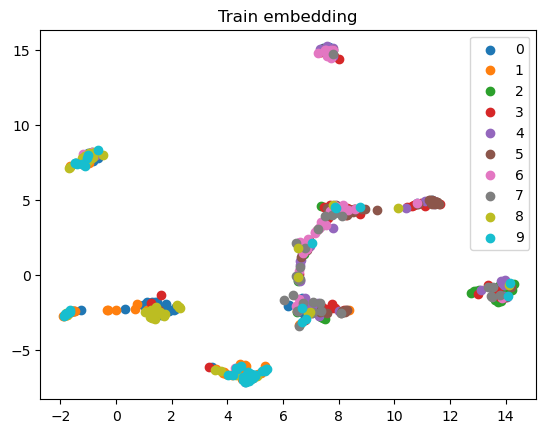

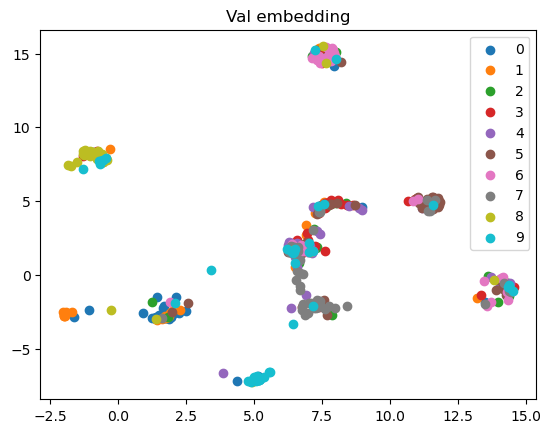

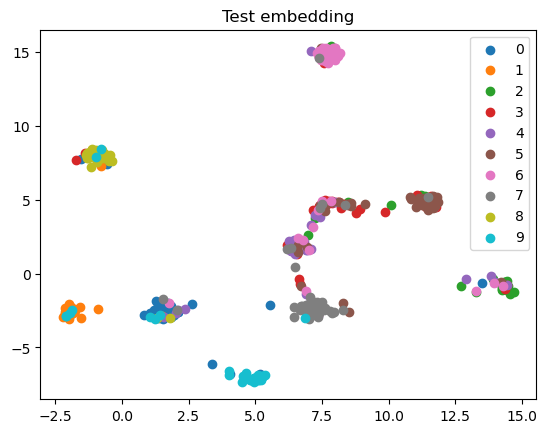

In [80]:
np.shape(test_umap)

for l in np.unique(train_lab):
    plt.scatter(train_umap[:, 0][train_lab[:500]==l], train_umap[:, 1][train_lab[:500]==l], label=int(l))
plt.title("Train embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(val_umap[:, 0][val_lab[:500]==l], val_umap[:, 1][val_lab[:500]==l], label=int(l))
plt.title("Val embedding")
plt.legend()
plt.show()

for l in np.unique(train_lab):
    plt.scatter(test_umap[:, 0][test_lab[:500]==l], test_umap[:, 1][test_lab[:500]==l], label=int(l))
plt.legend()
plt.title("Test embedding")
plt.show()